In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
import hdbscan

## Identifying clusters in the 100 pc sphere

<span style="font-size:18px;">

* Clustering in the 100 pc sphere is a challenging task.
* The data is un-evenly dense in two respective subspaces. Especially the velocity space is subject to strong non-linear projection effects.
* An originally compact Gaussian point cloud can result in a highly non-convex shape in the velocity space.

Let's see what this might look like in practice.

</span>

In [2]:
# Plotting related stuff
alphas = [0.9, 0.9, 0.3]
colors = ['tab:red', 'tab:blue', 'tab:grey']
zorders = [1, 1, 0]
log = True

In [3]:
# Create 6D Gaussian data
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50

mu = np.array([-5, 5, 5, 5, -5, 5])
c_xx = c_yy = 20
c_xy = 15
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2)

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2], axis=0)
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_bg = np.where(labels==0)[0]

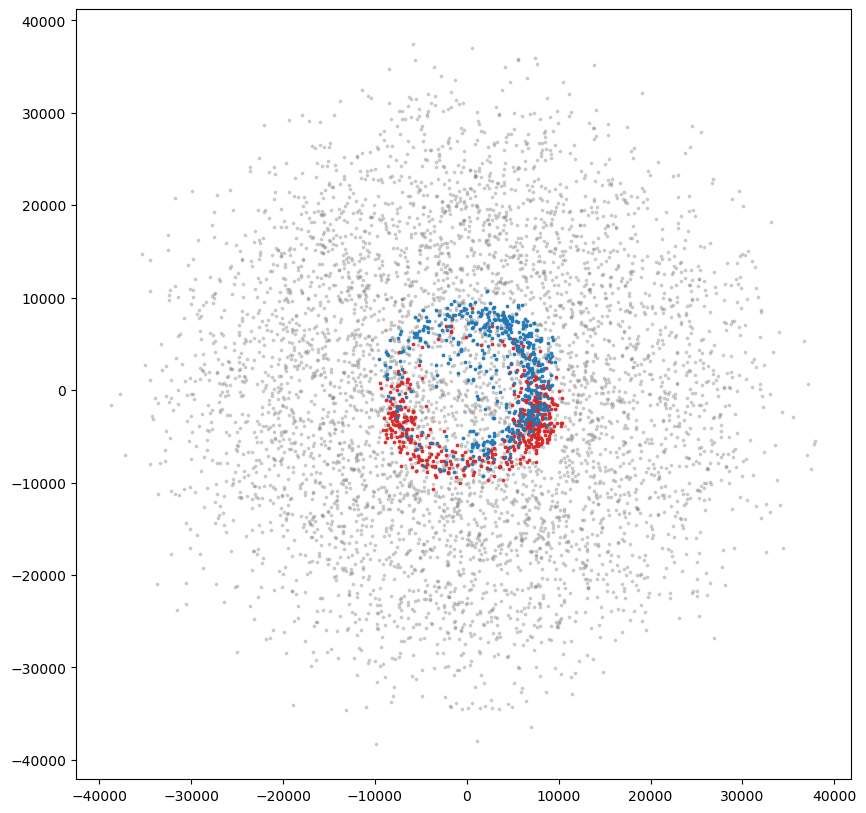

In [105]:
# x_col, y_col = 'x', 'y'
# x_col, y_col = 'vx', 'vy'
x_col, y_col = 'vt_ra', 'vt_dec'
# x_col, y_col = 'pmra', 'pmdec'

fig = plt.figure(figsize=(10, 10))
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_bg], alphas, colors, zorders):
    # if c == 'tab:blue':
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
# plt.xlim(-1000, 1000)
# plt.ylim(-1000, 1000)

## Density-based clustering assumptions

<span style="font-size:18px;">

* Data points in the same cluster are close to each other. 
* And they are dense areas separated by low-density regions.

$\to$ This is not the case in the proper motion or tangential velocity space. 

**BUT**: Cluster points should have similar 3D velocities. In Cartesian space, pairwise velocity differences should be minimal.

</span>

## Idea: Optimal velocity difference

<span style="font-size:18px;">

Compute pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars.

$$ ||\Delta v_{1, 2}|| = || \mathbf{v}_1 - \mathbf{v}_2 || = \sqrt{(U_1 - U_2)^2 + (V_1 - V_2)^2 + (W_1 - W_2)^2} $$

With $\mathbf{v}_1 = (U_1, V_1, W_1)^{T}$ and $\mathbf{v}_2 = (U_2, V_2, W_2)^T$.
</span>

## Idea: Optimal radial velocity

<span style="font-size:18px;">

We only have access to the tangential velocities of stars. Assuming we have a measurement of the radial velocity of a star, we can compute the 3D velocity of the star from its tangential velocity and the radial velocity.

$$ \mathbf{v} = T(\mathbf{x}) \mathbf{q} $$

With $\mathbf{q} = (\mu_{\alpha*}, \mu_{\delta}, v_{\text{rad}})^T$ and $T(\mathbf{x})$ the transformation matrix.
\\
\\
Then we can compute the pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars.
$$ ||\Delta v|| = || v_1 - v_2 || = || T(\mathbf{x_1}) \mathbf{q_1} - T(\mathbf{x_2}) \mathbf{q_2}|| $$

To find the optimal radial velocity, we can minimize the pairwise 3D velocity difference by computing the gradient of ||$\Delta v$|| with respect to $v_{\text{rad}_{(1,2)}}$ and setting it to zero:

$$ \frac{\partial ||\Delta v||}{\partial v_{\text{rad}_{(1,2)}}} = 0 $$

Solving this set of two equations is a little tedious by hand but nevertheless can be done analytically.

</span>

# Optimal radial velocity class
VrOpt computes pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars.

In [5]:
est = VrOpt(ra, dec, pmra, pmdec, dist)

In [48]:
# Create pairwise combinations of cluster indices
# # Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

In [30]:
# Create pairwise combinations of cluster indices
i, j = np.meshgrid(idx_cluster_2, idx_cluster_2)
i, j = i.flatten(), j.flatten()
# Remove values where i == j
mask = i != j
i, j = i[mask], j[mask]

delta_v_sig = dist_v_opt[i, j]

In [31]:
# Create pairwise combinations of background and signal indices
# n, m = np.meshgrid(idx_cluster_1, idx_cluster_2)
n, m = np.meshgrid(idx_cluster_1, idx_bg)
n, m = n.flatten(), m.flatten()

delta_v_bg = dist_v_opt[n, m]

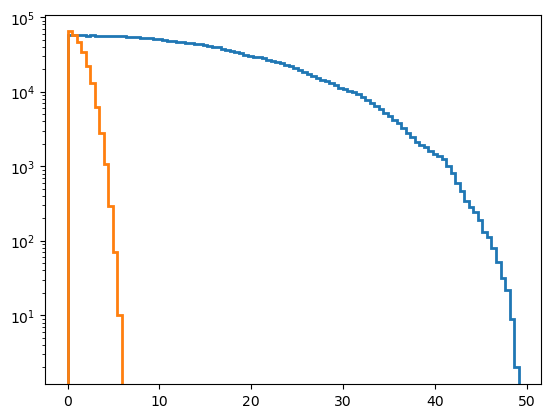

In [32]:
_, bins, _ = plt.hist(delta_v_bg, bins=100, log=log, histtype='step', lw=2)
plt.hist(delta_v_sig, bins=bins, log=log, histtype='step', lw=2);

# Comparison to tangential velocity differences

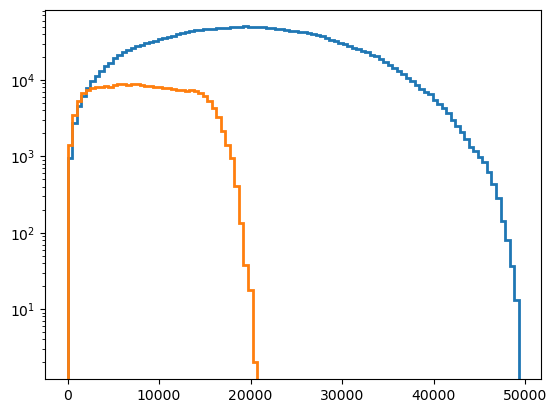

In [33]:
# Compute pair wise differences
X_vt = df[['vt_ra', 'vt_dec']].values
dist_vt = pairwise_distances(X_vt)

_, bins, _ = plt.hist(dist_vt[n, m], bins=100, log=True, histtype='step', lw=2)
plt.hist(dist_vt[i, j], bins=bins, log=True, histtype='step', lw=2);

# First cluster with HDBSCAN

In [10]:
# Cluster data naively using HDBSCAN
clusterer_classic = hdbscan.HDBSCAN(min_cluster_size=30, metric='l2')
df_fit = df[['x', 'y', 'z', 'vt_ra', 'vt_dec']]
df_fit[['vt_ra', 'vt_dec']] /= 100  
clusterer_classic.fit(df_fit)

labels_classic = clusterer_classic.labels_
# labels_classic[labels_classic == 1] = 0
print(normalized_mutual_info_score(labels, labels_classic))

0.3474084629268204


/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_11840/1466584001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit[['vt_ra', 'vt_dec']] /= 100


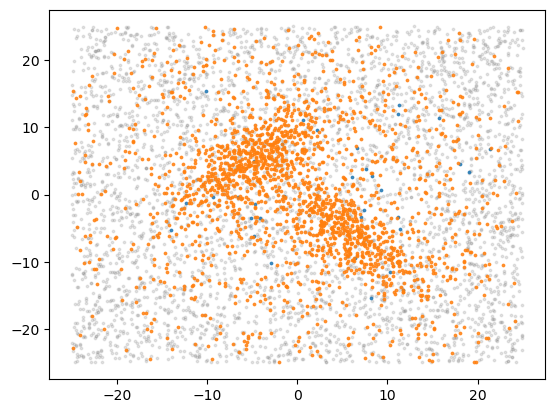

In [11]:
# x_col, y_col = 'vt_ra', 'vt_dec'
x_col, y_col = 'x', 'y'
for l_i in np.unique(labels_classic):
    idx_sel = labels_classic == l_i
    if l_i != -1:
        plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, alpha=0.8, zorder=1)

plt.scatter(df.loc[labels_classic==-1, x_col], df.loc[labels_classic==-1, y_col], s=3, alpha=0.2, c='tab:grey', zorder=0)

# Now built the distance matrix for clustering ourselves

In [12]:
# # Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

## Combine the two subspaces

<span style="font-size:18px;">

Combine the "semi-metric" distance matrix that encodes the velocity information with the (metric) pairwise distance matrix in the 3D positional space. This introduces additional discriminative power to separate the clusters from each other. 

</span> 

In [13]:
# Also bring distance into it
dist_xyz = pairwise_distances(df[['x', 'y', 'z']].values)

In [14]:
# Mix the two distance matrices
alpha = 0.8
dist_tot = alpha * dist_v_opt + (1 - alpha) * dist_xyz

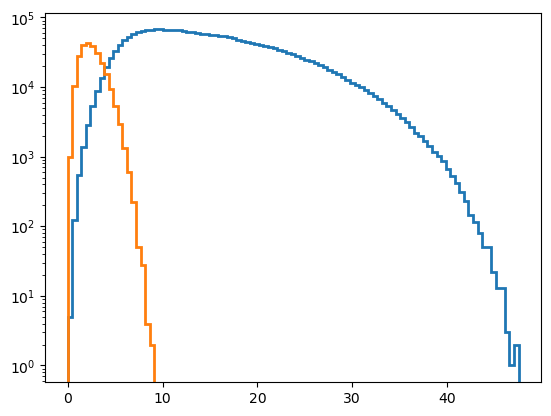

In [15]:
# Plot the combined distance matrix
max_val = np.max([np.max(dist_tot[i, j]), np.max(dist_tot[n, m])])
_, bins, _ = plt.hist(dist_tot[n, m], bins=np.linspace(0, max_val, 100), log=True, histtype='step', lw=2)
plt.hist(dist_tot[i, j], bins=bins, log=True, histtype='step', lw=2);

In [16]:
# Cluster points using the combined distance matrix
clusterer = AgglomerativeClustering(linkage='complete', metric='precomputed', distance_threshold=10, n_clusters=None)
clusterer.fit(dist_tot)

AgglomerativeClustering(distance_threshold=10, linkage='complete',
                        metric='precomputed', n_clusters=None)

In [17]:
cl_id, cl_count = np.unique(clusterer.labels_, return_counts=True)

# Keep only the largest cluster
min_cluster_size = 50  # Minimum number of points in a cluster
labels_new = -np.ones_like(clusterer.labels_)

for cl_i in cl_id:
    if np.sum(clusterer.labels_==cl_i) > min_cluster_size:
        print(cl_i, cl_i)
        labels_new[clusterer.labels_ == cl_i] = cl_i 

# labels_new[clusterer.labels_ == cl_id[np.argmax(cl_count)]] = 1
np.unique(labels_new, return_counts=True)
normalized_mutual_info_score(labels, labels_new)

86 86
219 219


0.8632170296409277

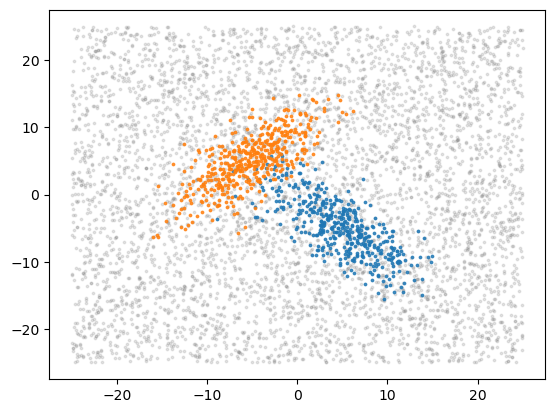

In [18]:
# x_col, y_col = 'vt_ra', 'vt_dec'
x_col, y_col = 'x', 'y'
# x_col, y_col = 'pmra', 'pmdec'
for l_i in np.unique(labels_new):
    if l_i != -1:
        idx_sel = labels_new == l_i
        plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, alpha=0.8, zorder=1)
        
plt.scatter(df.loc[labels_new==-1, x_col], df.loc[labels_new==-1, y_col], s=3, alpha=0.2, c='tab:grey', zorder=0)

In [19]:
nmi_hdbscan = normalized_mutual_info_score(labels, labels_classic)
nmi_own = normalized_mutual_info_score(labels, labels_new)

print(f"NMI HDBSCAN: {nmi_hdbscan:.2f}, NMI Own: {nmi_own:.2f}")

NMI HDBSCAN: 0.35, NMI Own: 0.86


## Embed data points in 3D space using MDS

In [20]:
# Embded data points in 3D space using mds
from sklearn.manifold import MDS

embedding = MDS(n_components=3, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(dist_v_opt)

/Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [106]:
# Plot with plotly in 3D
import plotly.express as px

fig = px.scatter_3d(x=X_transformed[:, 0], y=X_transformed[:, 1], z=X_transformed[:, 2], color=labels_new, opacity=0.8)

# make plot larger
fig.update_layout(width=800, height=800)


fig.show()

## Find communities in the semi metric space by spectral clustering

In [21]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

clusterer_spectral = SpectralClustering(n_clusters=3, affinity='precomputed_nearest_neighbors', n_init=5).fit(dist_v_opt)
labels_spectral = clusterer_spectral.labels_

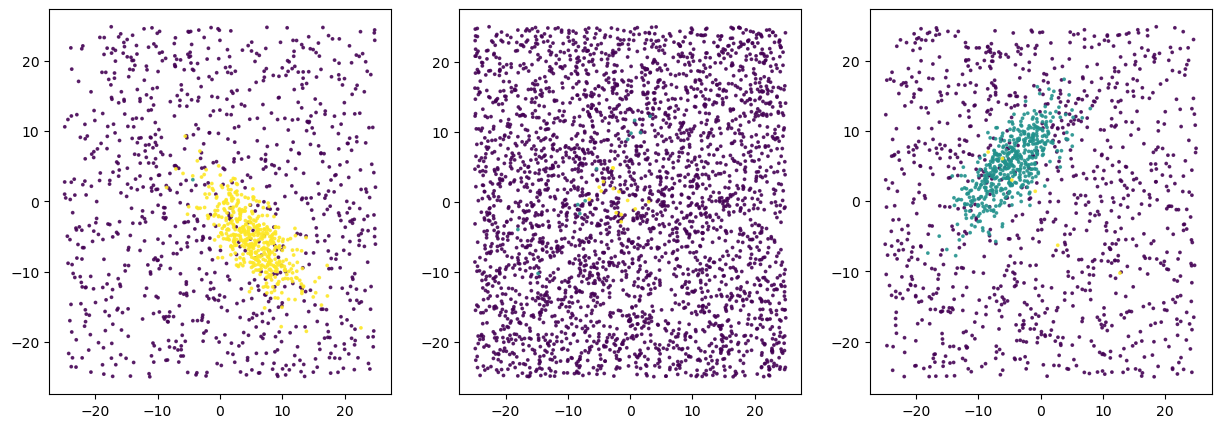

In [22]:
# x_col, y_col = 'vt_ra', 'vt_dec'
x_col, y_col = 'x', 'y'
# x_col, y_col = 'pmra', 'pmdec'

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for l_i in np.unique(labels_spectral):
    if l_i != -1:
        idx_sel = labels_spectral == l_i
        ax[l_i].scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, alpha=0.8, zorder=1, c=labels[idx_sel])
        
# plt.scatter(df.loc[labels_spectral==-1, x_col], df.loc[labels_spectral==-1, y_col], s=3, alpha=0.2, c='tab:grey', zorder=0)

# TODO:

## Compute the semi-cohesion metric

<span style="font-size:18px;">

Given a semi-metric d(·,·) for $\Omega$, we define the induced semi-cohesion measure as follows:

$$ g(x, y) = \frac{1}{n} \sum_{z_2 \in \Omega} d(z_2, y) + \frac{1}{n} \sum_{z_1 \in \Omega} d(x, z_1) - \frac{1}{n^2}  \sum_{z_2 \in \Omega} \sum_{z_1 \in \Omega} d(z_2, z_1) - d(x, y) $$ 

</span>


In [76]:
# Compute semi-cohesion metric G
G = np.copy(dist_v_opt)
G = np.full_like(G, np.sum(G, axis=0)/len(G)) + np.full_like(G, np.sum(G, axis=0)/len(G)).T - np.sum(G)/len(G)**2 - G

## TODO: Implement the K-sets+ algomrithm

<span style="font-size:18px;">
Implement the K-sets+ algorithm from this paper that uses the above computed semi-cohesion metric, see [here](https://arxiv.org/pdf/1705.04249).

</span>